# py4DSTEM tutorial 6: Calculate strain maps

Here we refine our initial lattice vector guess by fitting lattice vectors to the set of detected Bragg peaks in each diffraction pattern.  Then we use the changes in the lattice vectors to calculate the strain.

In [25]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing
from scipy.signal import medfilt

from py4DSTEM.file.datastructure import RealSlice, PointList
from py4DSTEM.file.io import FileBrowser, read, append

from py4DSTEM.process.latticevectors import index_bragg_directions, fit_lattice_vectors, fit_lattice_vectors_all_DPs
from py4DSTEM.process.latticevectors import get_strain_from_reference_region
from py4DSTEM.process.utils import get_maxima_2D

In [2]:
# Load data

fp = "/home/ben/Data/20180905_FePO4_unlithiated/h5/Sample_LFP_datacube.h5"
dc = py4DSTEM.file.io.read(fp)                                                # Get the datacube

fp = "/home/ben/Desktop/Sample_LFP_datacube_processing.h5"
browser = FileBrowser(fp)
braggpeaks = browser.get_dataobject('braggpeaks_shifted')
braggvectormap = browser.get_dataobject('braggvectormap_shiftcorrected').data2D
lattice_vectors = browser.get_dataobject('lattice_vectors')
browser.close()

/home/ben/Data/20180905_FePO4_unlithiated/h5/Sample_LFP_datacube.h5 is a py4DSTEM file, v0.4. Reading...


### Index Bragg directions

In [3]:
# Get beta, the lattice vector matrix
# Note that for the initial pass

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,2)),braggvectormap.shape)

ux = lattice_vectors.data['qx'][0]
uy = lattice_vectors.data['qy'][0]
vx = lattice_vectors.data['qx'][1]
vy = lattice_vectors.data['qy'][1]

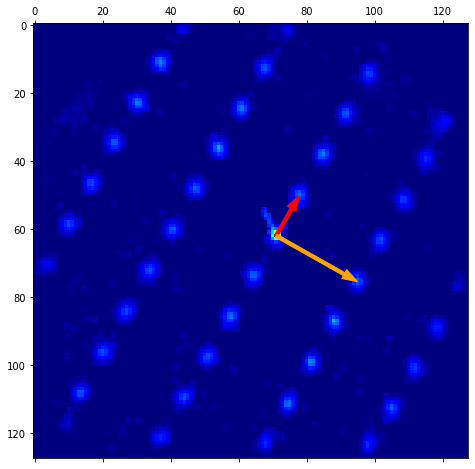

In [6]:
# Show bragg vector map and lattice vectors

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**0.25,cmap='jet')
ax.arrow(y0,x0,uy,ux, color='red',width=1,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=1,length_includes_head=True)
plt.show()

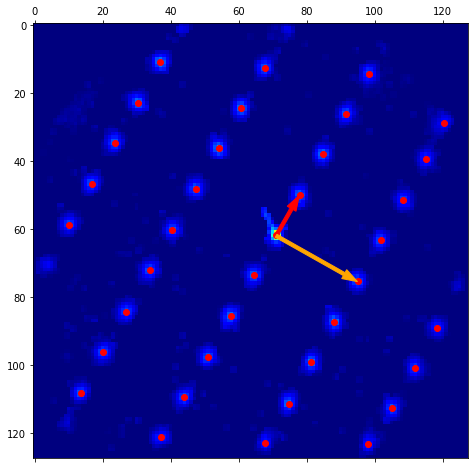

In [8]:
# Find Bragg vector map peak positions

sigma = 2
minSpacing = 8
minRelativeIntensity = 0.05
relativeToPeak = 1
maxNumPeaks = 40

power = 0.25

maxima_x,maxima_y,_ = get_maxima_2D(braggvectormap, sigma=sigma, minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                    relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks)

# Show
fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**power,cmap='jet')
ax.scatter(maxima_y,maxima_x,color='r')
ax.arrow(y0,x0,uy,ux, color='red',width=1,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=1,length_includes_head=True)
plt.show()

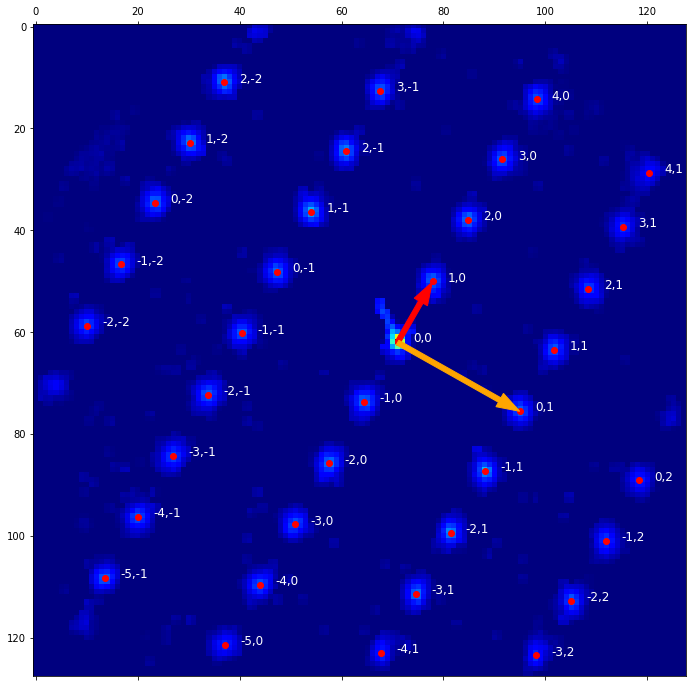

In [10]:
# Calculate indices

textoffset=3

# Get indices
h,k,bragg_directions = index_bragg_directions(x0,y0,ux,uy,vx,vy,maxima_x,maxima_y)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**.25,cmap='jet')
ax.scatter(bragg_directions.data['qy'],bragg_directions.data['qx'],color='r')
ax.arrow(y0,x0,uy,ux, color='red',width=1,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=1,length_includes_head=True)
for i in range(bragg_directions.length):
    ax.text(bragg_directions.data['qy'][i]+textoffset,bragg_directions.data['qx'][i],
            '{},{}'.format(bragg_directions.data['h'][i],bragg_directions.data['k'][i]),
            color='w',size=12)
plt.show()

### Fit lattice vectors

In [12]:
# Perform fit

maxPeakSpacing = 5
minNumPeaks = 6
x0,y0 = np.unravel_index(np.argmax(braggvectormap),braggvectormap.shape)

uv_map = fit_lattice_vectors_all_DPs(braggpeaks, bragg_directions, x0, y0, maxPeakSpacing, minNumPeaks)

### Calculate strain

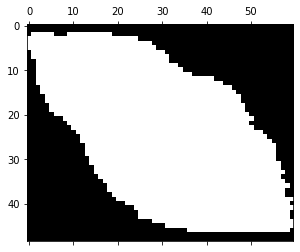

In [16]:
# Specify a region to use as the reference lattice
# Here we use the whole particle

mask = uv_map.data2D['mask'].astype(bool)

fig,ax = plt.subplots()
ax.matshow(mask,cmap='gray')
plt.show()

In [19]:
# Calculate strain

strain_map = get_strain_from_reference_region(mask,uv_map)

### Visualize strain maps

In [21]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

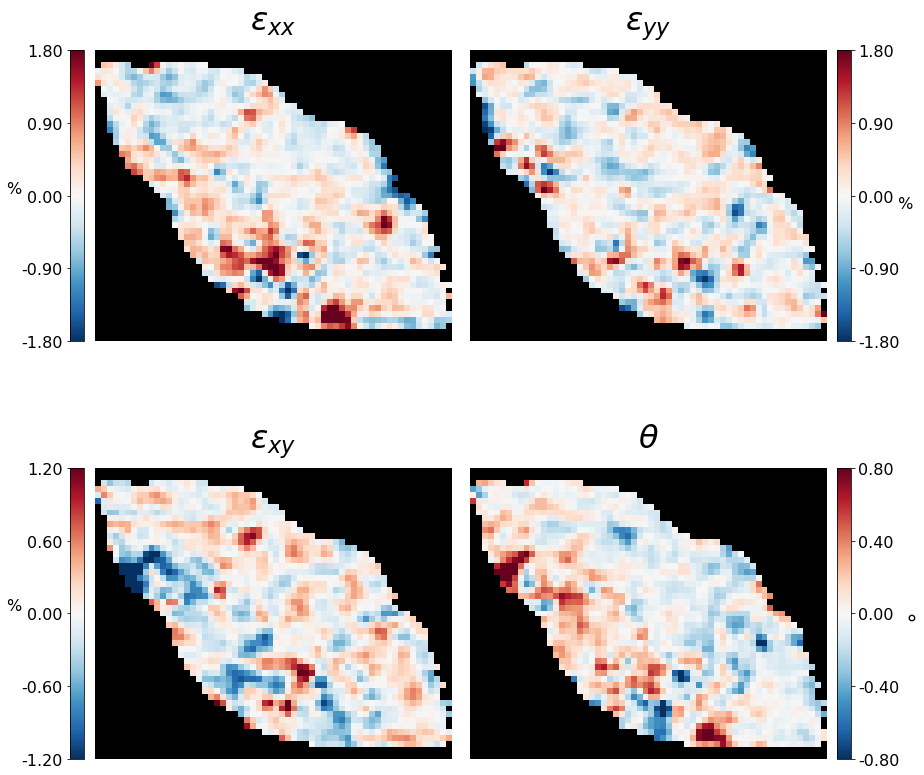

In [29]:
# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

sigma = .8
titlesize=32
ticklabelsize=16

# Set colorscales
automate_colorscale = False
n_stds=3

e_xx_range = [-1.8,1.8] # In percentage
e_yy_range = [-1.8,1.8] # In percentage
e_xy_range = [-1.2,1.2] # In percentage
theta_range = [-.8,.8] # In degrees



# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.data2D['e_xx'], medfilt(np.where(mask,strain_map.data2D['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.data2D['e_yy'], medfilt(np.where(mask,strain_map.data2D['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.data2D['e_xy'], medfilt(np.where(mask,strain_map.data2D['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.data2D['theta'], medfilt(np.where(mask,strain_map.data2D['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave, e_xx_std = np.average(e_xx_smoothed[mask]),np.std(e_xx_smoothed[mask])
e_yy_ave, e_yy_std = np.average(e_yy_smoothed[mask]),np.std(e_yy_smoothed[mask])
e_xy_ave, e_xy_std = np.average(e_xy_smoothed[mask]),np.std(e_xy_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

if automate_colorscale:
    e_xx_range = [-n_stds*e_xx_std*100,n_stds*e_xx_std*100]
    e_yy_range = [-n_stds*e_yy_std*100,n_stds*e_yy_std*100]
    e_xy_range = [-n_stds*e_xy_std*100,n_stds*e_xy_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]

### Plot ###
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,
                                             figsize=(14,15),
                                             gridspec_kw={'wspace':0.05,'hspace':0.05})

cax11 = ax11.matshow(e_xx_smoothed,vmin=e_xx_range[0]/100., vmax=e_xx_range[1]/100., cmap="RdBu_r")
cax12 = ax12.matshow(e_yy_smoothed,vmin=e_yy_range[0]/100., vmax=e_yy_range[1]/100., cmap="RdBu_r")
cax21 = ax21.matshow(e_xy_smoothed,vmin=e_xy_range[0]/100., vmax=e_xy_range[1]/100., cmap="RdBu_r")
cax22 = ax22.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax11.matshow(plot_mask,cmap='gray')
ax12.matshow(plot_mask,cmap='gray')
ax21.matshow(plot_mask,cmap='gray')
ax22.matshow(plot_mask,cmap='gray')

# Colorbars
divider11 = make_axes_locatable(ax11)
divider12 = make_axes_locatable(ax12)
divider21 = make_axes_locatable(ax21)
divider22 = make_axes_locatable(ax22)
cbax11 = divider11.append_axes("left", size="4%", pad=0.15)
cbax12 = divider12.append_axes("right", size="4%", pad=0.15)
cbax21 = divider21.append_axes("left", size="4%", pad=0.15)
cbax22 = divider22.append_axes("right", size="4%", pad=0.15)

cb11 = plt.colorbar(cax11, cax=cbax11, ticks=np.linspace(e_xx_range[0]/100.,e_xx_range[1]/100.,5,endpoint=True))
cb12 = plt.colorbar(cax12, cax=cbax12, ticks=np.linspace(e_yy_range[0]/100.,e_yy_range[1]/100.,5,endpoint=True))
cb21 = plt.colorbar(cax21, cax=cbax21, ticks=np.linspace(e_xy_range[0]/100.,e_xy_range[1]/100.,5,endpoint=True))
cb22 = plt.colorbar(cax22, cax=cbax22, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True))

cb11.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xx_range[0],e_xx_range[1],5,endpoint=True)],size=ticklabelsize)
cb12.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_yy_range[0],e_yy_range[1],5,endpoint=True)],size=ticklabelsize)
cb21.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xy_range[0],e_xy_range[1],5,endpoint=True)],size=ticklabelsize)
cb22.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax11.yaxis.set_ticks_position('left')
cbax21.yaxis.set_ticks_position('left')

cbax11.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax12.set_ylabel(" %", size=ticklabelsize, rotation=0)
cbax21.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax22.set_ylabel(r" $^\circ$", size=2*ticklabelsize, rotation=0)

cbax11.yaxis.set_label_position('left')
cbax12.yaxis.set_label_position('right')
cbax21.yaxis.set_label_position('left')
cbax22.yaxis.set_label_position('right')


ax11.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax12.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax21.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax22.set_title(r'$\theta$',size=titlesize)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')

plt.show()

### Save

In [30]:
# Append to processing file

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append([uv_map,strain_map], fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
